# Figure 12: Turbine vs Wind-Current Effects

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.simplefilter('ignore')

import numpy as np
from matplotlib import pyplot
from matplotlib import gridspec

import pandas as pd
import xarray as xr


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
from datetime import datetime
from scipy.stats import geom
from glob import glob

import cmocean.cm as cmo
import xroms
import os

from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
from shapely.geometry.polygon import LinearRing

import time
import glob
import os


In [2]:
# Read in datasets

root = '/qfs/people/hins978/Notebooks/Kestrel_Notebooks/Turbine_outputs_CoupledCOAWST/'
bwmb = xr.open_dataset(root+'BaseWC-Base.nc')
twmbw = xr.open_dataset(root+'TurbWC-BaseWC.nc')
tmb = xr.open_dataset(root+'Turb-Base.nc')
twmt = xr.open_dataset(root+'TurbWC-Turb.nc')

In [3]:
# Load in Time Series Data

ts_bwmb = np.load(root+'BaseWC-Base.npz')
ts_twmbw = np.load(root+'TurbWC-BaseWC.npz')
ts_tmb = np.load(root+'Turb-Base.npz')
ts_twmt = np.load(root+'TurbWC-Turb.npz')

In [4]:
fname = 'test_roms_temp.nc'
test_ds = xr.open_dataset(fname, chunks={'ocean_time': 1})

In [5]:
# grab lon/lat to plot extent of dipole

lonc0 = test_ds.lon_rho[210,285].values
lonc1 = test_ds.lon_rho[229,285].values
lonc2 = test_ds.lon_rho[229,311].values
lonc3 = test_ds.lon_rho[210,311].values

latc0 = test_ds.lat_rho[210,285].values
latc1 = test_ds.lat_rho[229,285].values
latc2 = test_ds.lat_rho[229,311].values
latc3 = test_ds.lat_rho[210,311].values

lonring = np.hstack((lonc0, lonc1, lonc2, lonc3))
latring = np.hstack((latc0, latc1, latc2, latc3))

ring = LinearRing(list(zip(lonring, latring)))

In [6]:
# Create time vector for plotting

xtaxi = pd.date_range(start='8/1/2021', end='9/1/2021', freq='4D')

plt_taxi = []
for i in xtaxi:
    plt_taxi.append(i.strftime('%b-%d'))

In [13]:
print(ts_bwmb['tdelta'].mean())
print(ts_twmt['tdelta'].mean())
print(ts_tmb['tdelta'].mean())
print(ts_twmbw['tdelta'].mean())

0.08880203
0.08705297
0.02309446
0.021845128


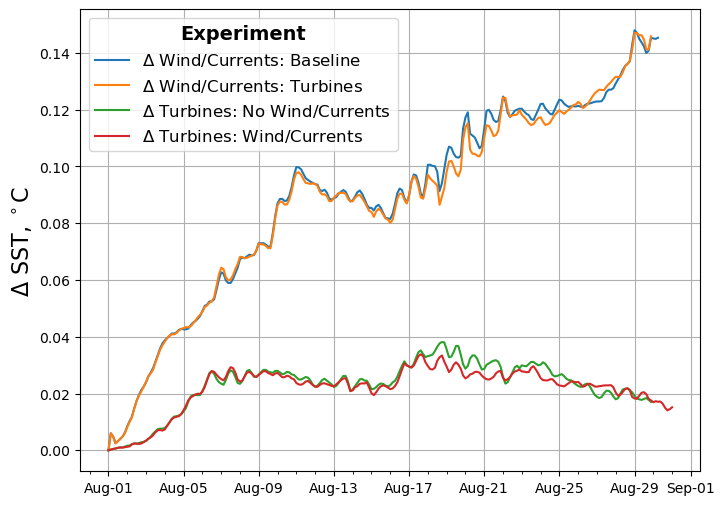

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(ts_bwmb['taxi'],ts_bwmb['tdelta'], label='$\Delta$ Wind/Currents: Baseline')
ax.plot(ts_twmt['taxi'],ts_twmt['tdelta'], label='$\Delta$ Wind/Currents: Turbines')
ax.plot(ts_tmb['taxi'],ts_tmb['tdelta'], label='$\Delta$ Turbines: No Wind/Currents')
ax.plot(ts_twmbw['taxi'],ts_twmbw['tdelta'], label='$\Delta$ Turbines: Wind/Currents')

ax.grid()
l1 = ax.legend(title_fontproperties={'weight':'bold', 'size':14}, fontsize=12)
l1.set_title('Experiment')
ax.set_ylabel('$\Delta$ SST, $^\circ$C', fontsize=16)

date_format = mdates.DateFormatter('%b-%d')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_minor_locator(mdates.DayLocator())

Text(0.5, 1.0, 'WindCur-Base minus Base-Coupled')

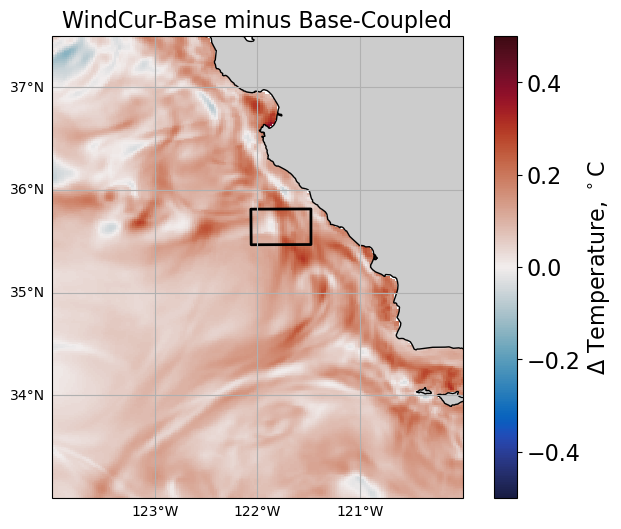

In [16]:
# Plot annual average

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=proj)


coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = bwmb.temp.plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.5, vmax=0.5,
                                 add_colorbar=False)

pc.set_clim(-0.5, 0.5)
cb = fig.colorbar(pc)
cb.set_label('$\Delta$ Temperature, $^\circ$C', fontsize=16)
cb.ax.tick_params(labelsize=16)

ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False
  
ax.set_extent([-124, -120, 33, 37.5], crs=ccrs.PlateCarree())
ax.set_title('WindCur-Base minus Base-Coupled', fontsize=16)


Text(0.5, 1.0, 'WindCur-Turb minus WindCur-Base')

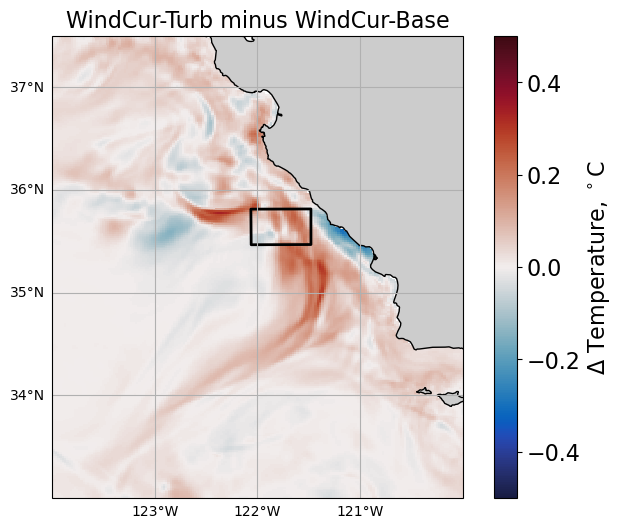

In [17]:
# Plot annual average

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=proj)


coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = twmbw.temp.plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.5, vmax=0.5,
                                 add_colorbar=False)

pc.set_clim(-0.5, 0.5)
cb = fig.colorbar(pc)
cb.set_label('$\Delta$ Temperature, $^\circ$C', fontsize=16)
cb.ax.tick_params(labelsize=16)

ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False
  
# ax.set_extent([-125.3, -119, 32.5, 38], crs=ccrs.PlateCarree())
ax.set_extent([-124, -120, 33, 37.5], crs=ccrs.PlateCarree())
ax.set_title('WindCur-Turb minus WindCur-Base', fontsize=16)


In [15]:
plot_taxi = pd.to_datetime('2021-08-31', format='%Y-%m-%d')
plot_taxi

Timestamp('2021-08-31 00:00:00')

In [17]:
lonc0 = twmbw.temp.lon_rho[ 75,200].values
lonc1 = twmbw.temp.lon_rho[325,200].values
lonc2 = twmbw.temp.lon_rho[325,400].values
lonc3 = twmbw.temp.lon_rho[ 75,400].values

latc0 = twmbw.temp.lat_rho[ 75,200].values
latc1 = twmbw.temp.lat_rho[325,200].values
latc2 = twmbw.temp.lat_rho[325,400].values
latc3 = twmbw.temp.lat_rho[ 75,400].values

alonring = np.hstack((lonc0, lonc1, lonc2, lonc3))
alatring = np.hstack((latc0, latc1, latc2, latc3))

aring = LinearRing(list(zip(alonring, alatring)))

In [19]:
# calculate average change for manuscript

print(bwmb.temp.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).mean().values.item())
print(bwmb.temp.isel(xi_rho=slice(200, 400), eta_rho=slice(75, 325)).std().values.item())

0.0888020247220993
0.05332184582948685


### Add in the ROMS lines

In [20]:
# Grab and read in relevant ROMS files
sfiles = glob.glob('/rcfs/scratch/hins978/OCCAMS_ROMS/kstrl_modrun_202108/ocean_his_*.nc')
sfiles.sort()
base_ds = xr.open_mfdataset(sfiles, chunks={'ocean_time': 1})

In [21]:
# Grab and read in relevant ROMS files
sfiles = glob.glob('/rcfs/scratch/hins978/OCCAMS_ROMS/kstrlTurbine_modrun_202108/ocean_his_*.nc')
sfiles.sort()
turb_ds = xr.open_mfdataset(sfiles, chunks={'ocean_time': 1})

In [22]:
# Grab and read in relevant ROMS files
sfiles = glob.glob('/rcfs/scratch/hins978/OCCAMS_ROMS/kstrl_wcBase_bfrc_202108/ocean_his_*.nc')
sfiles.sort()
wbase_ds = xr.open_mfdataset(sfiles, chunks={'ocean_time': 1})

In [23]:
# Grab and read in relevant ROMS files
sfiles = glob.glob('/rcfs/scratch/hins978/OCCAMS_ROMS/kstrl_wcTurb_tfrc_202108/ocean_his_*.nc')
sfiles.sort()
wturb_ds = xr.open_mfdataset(sfiles, chunks={'ocean_time': 1})

In [24]:
# Calculate differences for spatial changes

d0 = wbase_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325)) - base_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325))
d1 = wturb_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325)) - wbase_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325))
d2 = turb_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325)) - base_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325))
d3 = wturb_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325)) - turb_ds.temp.isel(s_rho=-1, xi_rho=slice(200, 400), eta_rho=slice(75, 325))


In [25]:
# Calculate Time Series Data
t0 = time.time()
rts_bwmb = d0.mean(dim=['eta_rho','xi_rho']).compute()
print(time.time() - t0)
rts_twmbw = d1.mean(dim=['eta_rho','xi_rho']).compute()
print(time.time() - t0)
rts_tmb = d2.mean(dim=['eta_rho','xi_rho']).compute()
print(time.time() - t0)
rts_twmt = d3.mean(dim=['eta_rho','xi_rho']).compute()
print(time.time() - t0)

6.741885662078857
104.85787010192871
207.30051946640015
208.15569019317627


In [27]:
plot_taxi = pd.to_datetime('2021-08-30 10:00:00', format='%Y-%m-%d %H:%M:%S')
plot_taxi

Timestamp('2021-08-30 10:00:00')

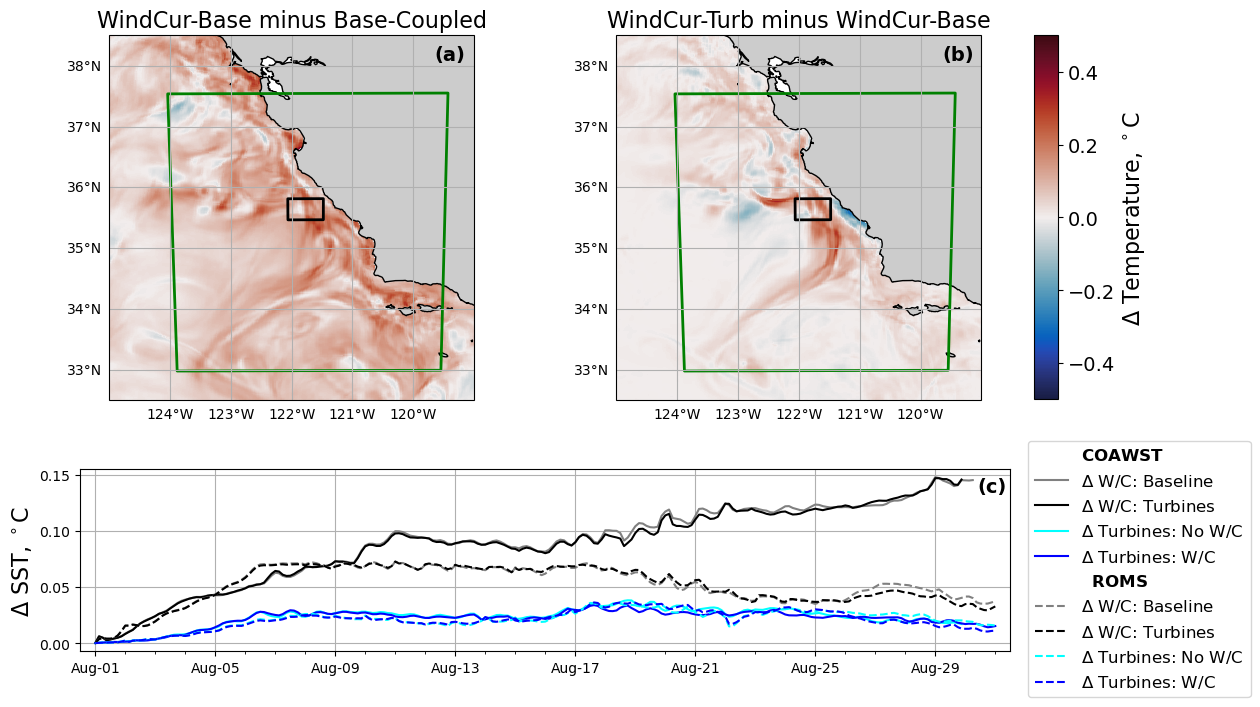

In [35]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 8))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], wspace=0.2, height_ratios=[1, 0.5], hspace=0.25)

#---------------------------------------------------------------------#
ax = plt.subplot(gs[0, 0], projection=proj)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = bwmb.temp.plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.5, vmax=0.5,
                                 add_colorbar=False)


ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
ax.add_geometries([aring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-125, -119, 32.5, 38.5], crs=ccrs.PlateCarree())
ax.set_title('WindCur-Base minus Base-Coupled', fontsize=16)
ax.text(-119.65, 38.1, '(a)', fontsize=14, fontweight='demibold')

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

ax = plt.subplot(gs[0, 1], projection=proj)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pc = twmbw.temp.plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.5, vmax=0.5,
                                 add_colorbar=False)


ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
ax.add_geometries([aring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2)


gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-125, -119, 32.5, 38.5], crs=ccrs.PlateCarree())
ax.set_title('WindCur-Turb minus WindCur-Base', fontsize=16)
ax.text(-119.65, 38.1, '(b)', fontsize=14, fontweight='demibold')

#---------------------------------------------------------------------#
# Adjust Colorbar
cax = fig.add_axes([0.92, 0.425, 0.02, 0.455])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)
cbar.ax.tick_params(labelsize=14)

#---------------------------------------------------------------------#
ax = plt.subplot(gs[1, :])

# COAWST Plots
x0 = ax.plot(ts_bwmb['taxi'][0],ts_bwmb['tdelta'][0], marker='None', linestyle='None', label=r'$\bf{COAWST}$')

c0 = ax.plot(ts_bwmb['taxi'],ts_bwmb['tdelta'], label='$\Delta$ W/C: Baseline', color='grey')
c1 = ax.plot(ts_twmt['taxi'],ts_twmt['tdelta'], label='$\Delta$ W/C: Turbines', color='black')
c2 = ax.plot(ts_tmb['taxi'],ts_tmb['tdelta'], label='$\Delta$ Turbines: No W/C', color='cyan')
c3 = ax.plot(ts_twmbw['taxi'],ts_twmbw['tdelta'], label='$\Delta$ Turbines: W/C', color='blue')

# ROMS Plots
x4 = ax.plot(ts_bwmb['taxi'][0],ts_bwmb['tdelta'][0], marker='None', linestyle='None', label=r'  $\bf{ROMS}$')

r0 = ax.plot(rts_bwmb['ocean_time'][0:241],rts_bwmb[0:241], label='$\Delta$ W/C: Baseline', color='grey', linestyle='--')
r1 = ax.plot(rts_twmt['ocean_time'],rts_twmt, label='$\Delta$ W/C: Turbines', color='black', linestyle='--')
r2 = ax.plot(rts_tmb['ocean_time'],rts_tmb, label='$\Delta$ Turbines: No W/C', color='cyan', linestyle='--')
r3 = ax.plot(rts_twmbw['ocean_time'],rts_twmbw, label='$\Delta$ Turbines: W/C', color='blue', linestyle='--')

ax.grid()

l1 = ax.legend(title_fontproperties={'weight':'bold', 'size':14}, fontsize=12, ncols=1,
               bbox_to_anchor=(1.01, 1.2))
ax.set_ylabel('$\Delta$ SST, $^\circ$C', fontsize=16)

date_format = mdates.DateFormatter('%b-%d')
ax = plt.gca()
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.text(plot_taxi, 0.135, '(c)', fontsize=14, fontweight='demibold')

dx0 = pd.to_datetime('2021-07-31 12:00:00')
dx1 = pd.to_datetime('2021-08-31 12:00:00')
ax.set_xlim([dx0, dx1])

savepath = '/qfs/people/hins978/Notebooks/Kestrel_Notebooks/'
fig.savefig(savepath+'WindCurrent_Impacts_CpdSolo_v3.png', format='png', dpi=300, bbox_inches='tight')